# Prétraitement d'images satellitaires Q1

## Enoncé :
Le prétraitement est l’ensemble des opérations requises avant l’analyse principale et
l’extraction de l’information, son but est de fournir à partir des images brutes des images
améliorées.
L'objectif de TP2 est présenté quelques opérations de prétraitement des images satellitaires,
nous allons donc voir comment faire quelques opérations comme les opérations géométriques,
la compression, le rehaussement de contraste et la restauration.
Pour l'application considérée nous allons utiliser une image acquise par le satellite LANDSAT 7
ETM+ (Enhanced Thematic Mapper plus) des zones côtières de Sumatra, en Indonésie, la date
d'acquisition est 14 Mai 2002. L’image est une composition naturelle de trois canaux : bandes
de ETM1, ETM2 et ETM3, sa taille en pixels 5760x7200 et elle contient les différentes classes
suivantes : la végétation, l'eau, les zones urbaines et non végétales.

Etape 1 : Opération géométrique
Les opérations géométriques ont pour but de modifier la position des informations contenues
dans l'image sans modifier le niveau de gris car cela supprime les erreurs de mesure dues aux
satellites (comme la variation d’altitude) ; à la rotondité de la terre ; …etc

In [3]:
import numpy as np
import time
import cv2
import matplotlib.image as mpimg    
import matplotlib.pyplot as plt    
import sys
from PIL import Image
from scipy import ndimage
from scipy import misc

## Etape 1

### 1- Création d’une fonction pour découper une zone sur l’image satellitaire RGB

On appliquera pour cette étape afin de découper une zone sur l’image satellitaire RGB une approche de croissance des régions, d’abord on créera une fonction pour obtenir les coordonnées à partir d’une clique dans l'image : on_mouse(event, x, y, flags, params). Ensuite : class point, une fonction pour obtenir la différence de couleur entre 2 points, fonction pour sélectionner les 8 voisins d'un point pour enfin arriver à la fonction de détection des région par croissance.

hover then click
Start Mouse Position: 515, 218
Starting region growing based on last click


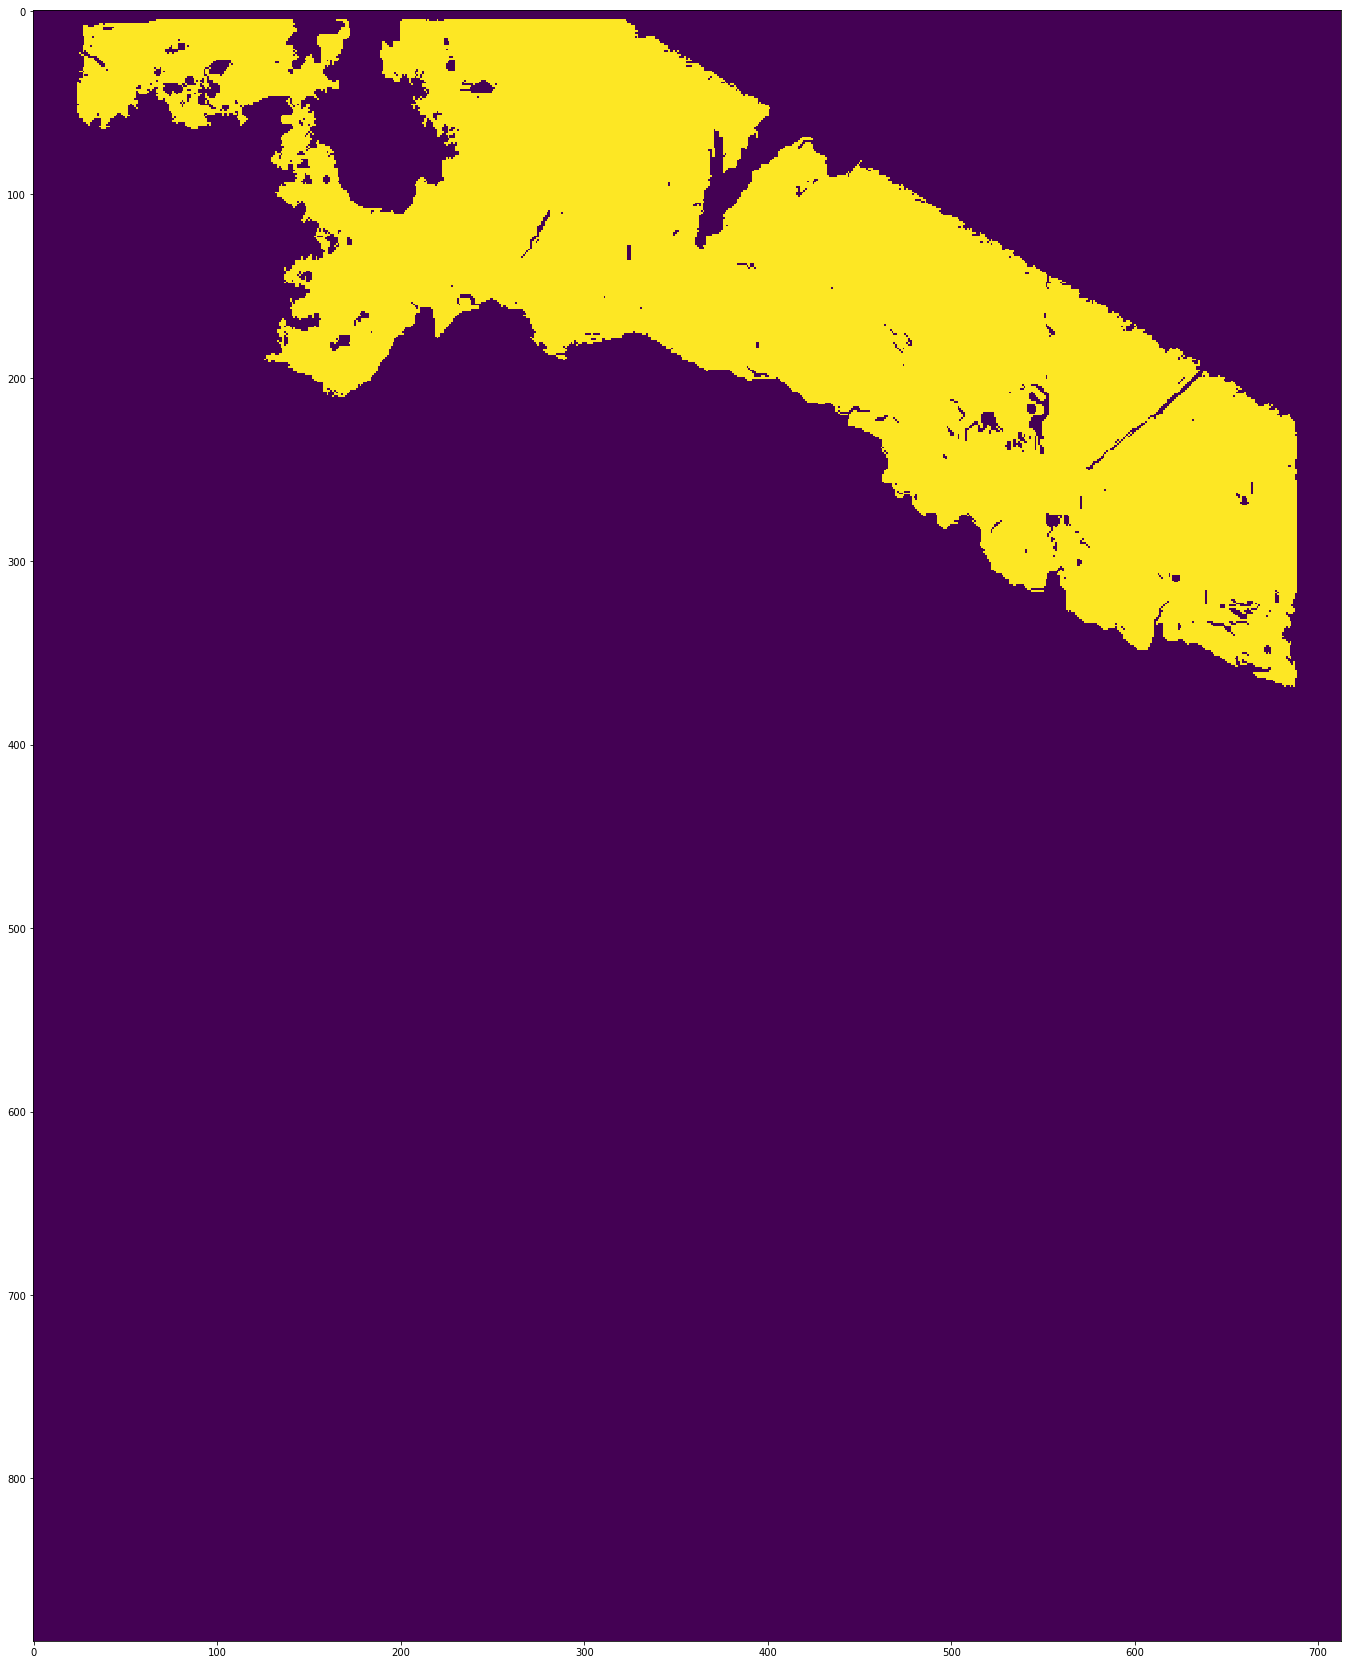

largeur: 362 hauteur: 665
Q1.jpg :


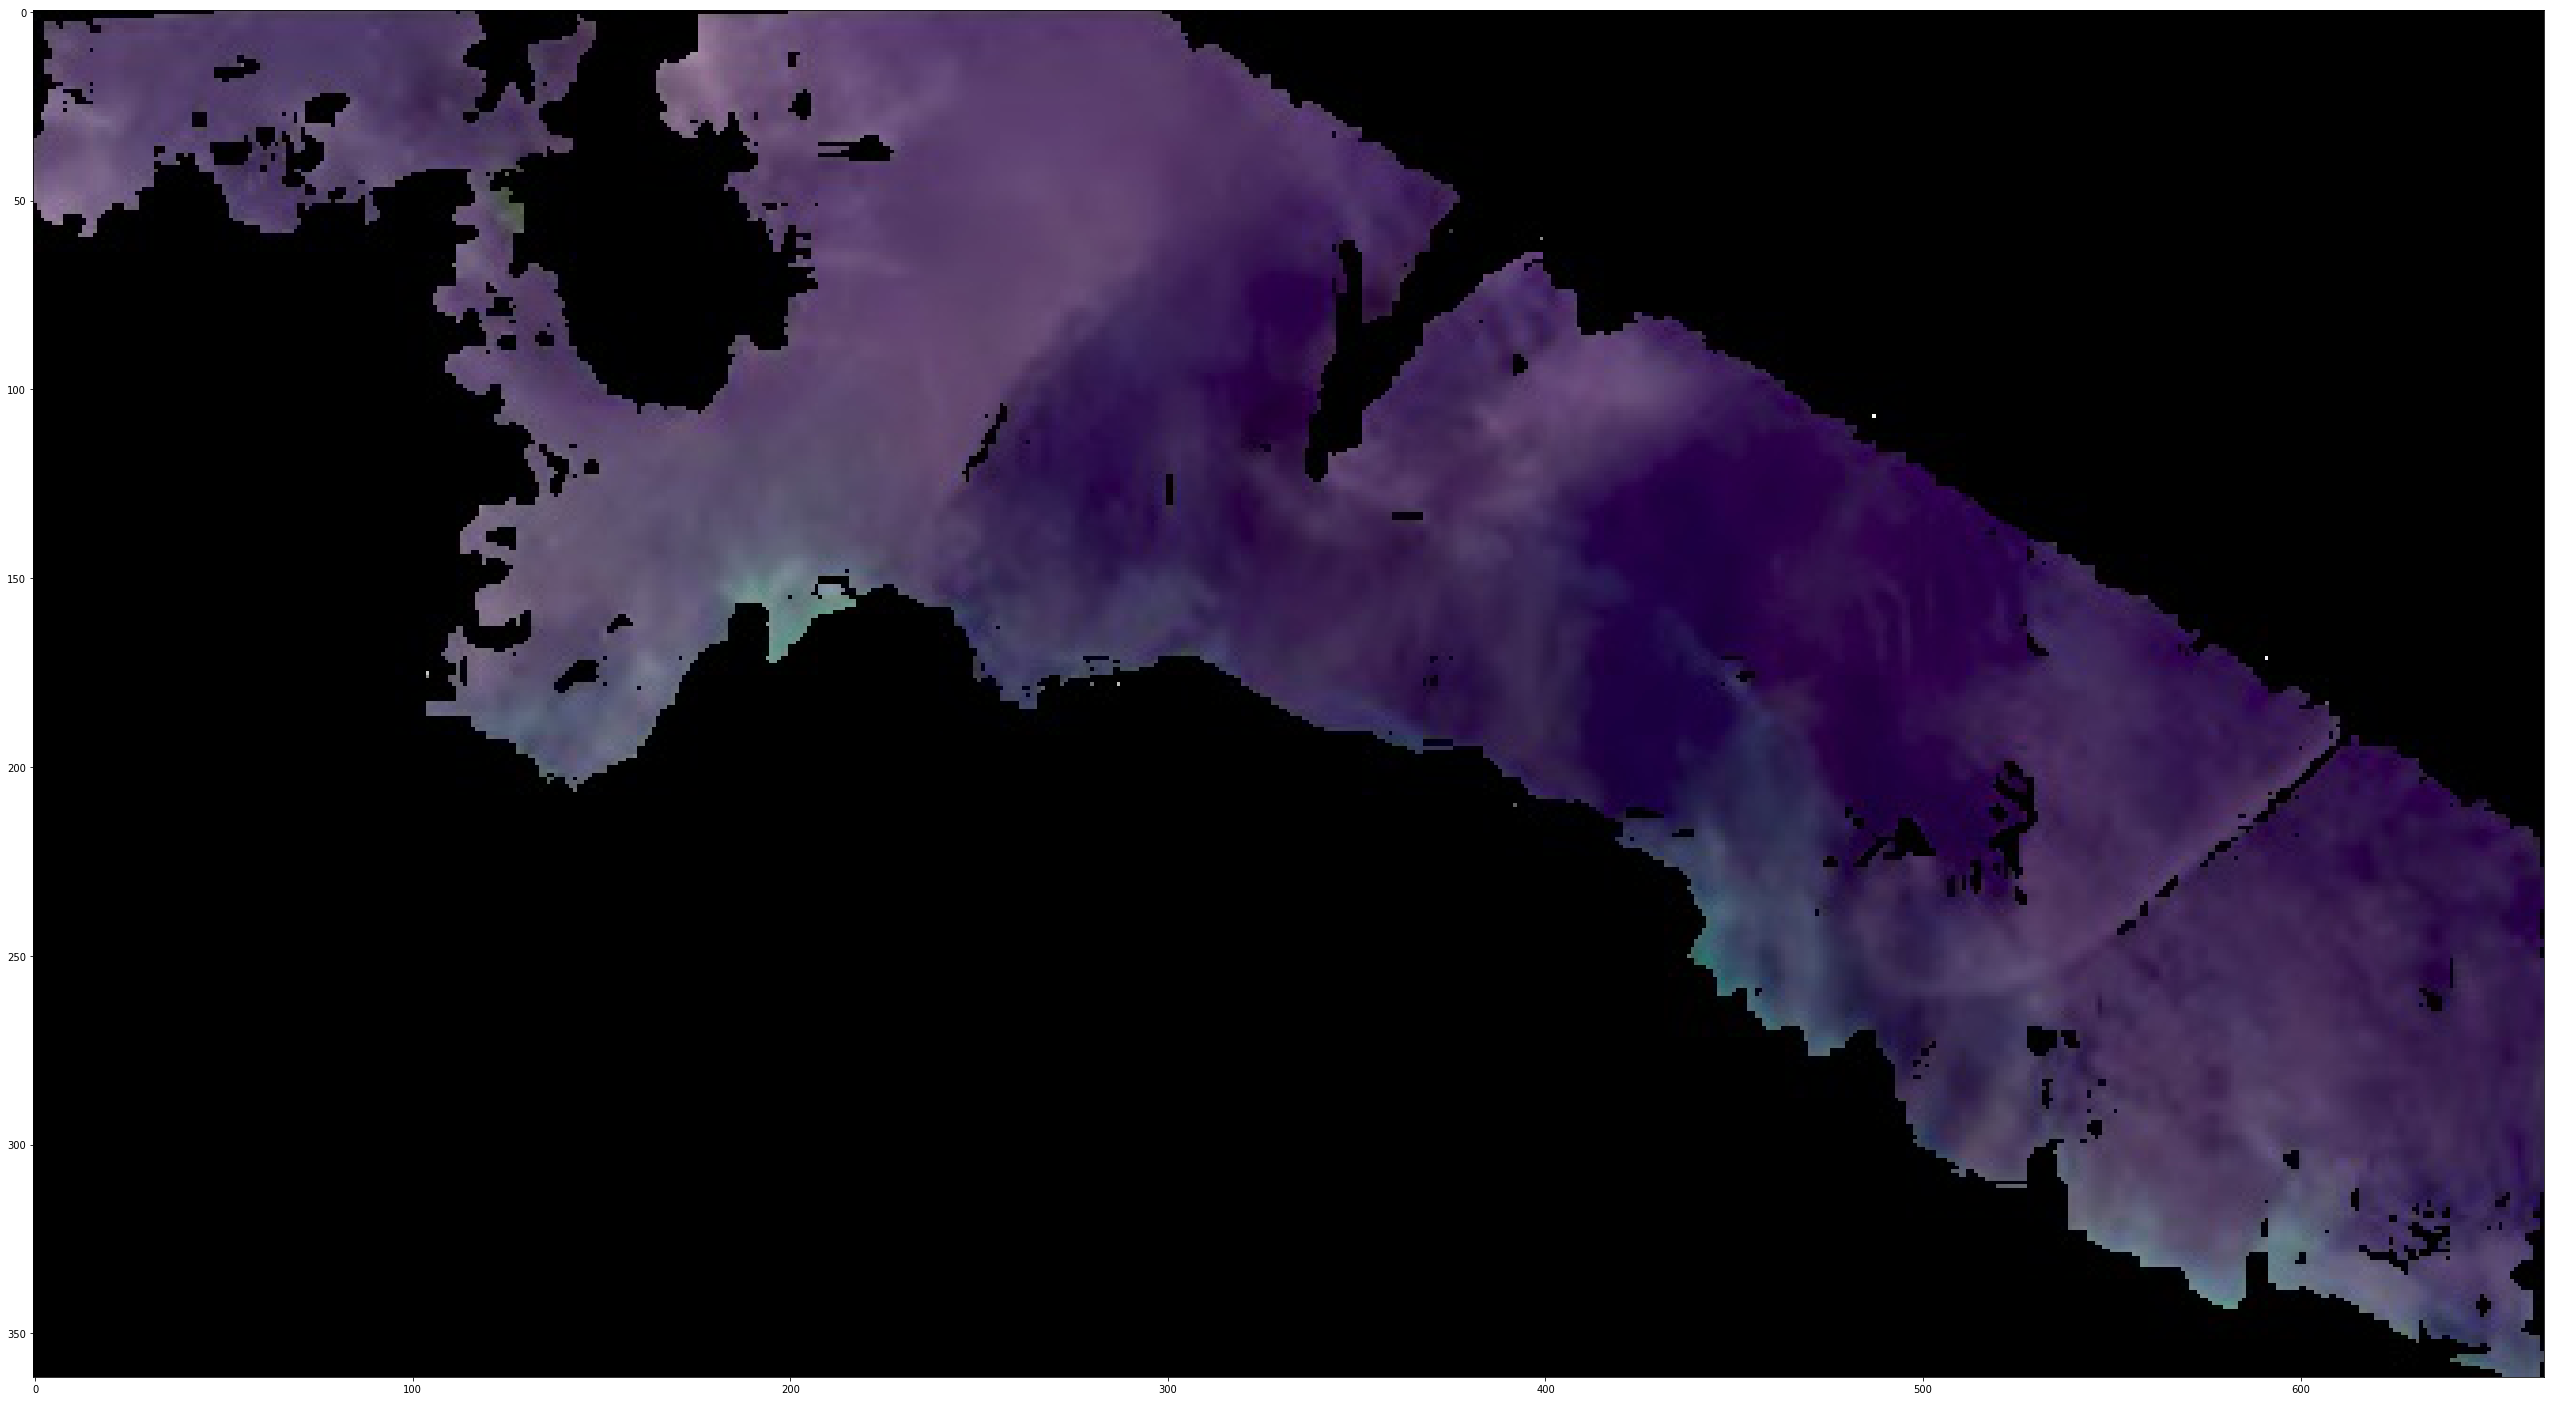

In [4]:
def ReadAffiche(ImageFile):
    try:
            img = mpimg.imread(ImageFile) #ImageFile est un input string of file text name (with extension) or with path
    except IOError: ##le cas si pas de fichier a lire
        print('Erreur sur ouverture du fichier ' + ImageFile)
        sys.exit(1)
        
        
    # affichage des caractéristiques de l'image
    Taillex,Tailley,z=img.shape    
    print("largeur:",Taillex,"hauteur:",Tailley)
    
    
    # affichage de l'image
    print(ImageFile+" :")
    
    plt.rcParams["figure.figsize"] = [45,30]
    plt.imshow(img)
    plt.show()
    return img



CURSOR_UP_ONE = '\x1b[1A' 
ERASE_LINE = '\x1b[2K' 

# fonction pour obtenir les coordonnées apartir de clique dans l'image 
def on_mouse(event, x, y, flags, params):#event= objet representatif du clique du souris
                                         #x,y les coordonés acueillis dans image ou le curseur de 
                                            #souris est superposé 
                                         #flags:
                                          #params:extra arguments (mbe façon argv en language c)
    #print(flags)
    #print(params)
    if event == cv2.EVENT_LBUTTONDOWN:##dans ac ou le click guache du souris est fectué
        print ('Start Mouse Position: ' + str(x) + ', ' + str(y)) #affichage de coordone avec conversion de
                                                                    # x,y vers string 
        s_box = x, y #acueil des coorone du pixel cliqué
        boxes.append(s_box)#ajout s_bow au variable gloabal (mbe) boxes

# cree une class point 
class Point(object):
    def __init__(self,x,y):##consturcteur du classe
        self.x = x #variable self refere au instance courant de ce classe
        self.y = y
    def getX(self):
        return self.x
    def getY(self):
        return self.y

# fonction pour obtenir la différence de couleur entre 2 points 
def getGrayDiff(img,currentPoint,tmpPoint):#les variables sont auto explicatives
    return abs(int(img[currentPoint.x,currentPoint.y]) - int(img[tmpPoint.x,tmpPoint.y]))

# fonction pour sélectionner les 8 voisins d'un point 
def selectConnects(p): #p est variable booléene en forme d'entier pour choisir les point voisin
    if p != 0: #si p est vrai
        connects = [Point(-1, -1), Point(0, -1), Point(1, -1), Point(1, 0), Point(1, 1), Point(0, 1), Point(-1, 1), Point(-1, 0)]
    return connects

# fonction pour detection du région par croissance
def regionGrow(img,seeds,thresh,p =1):  #p est variable booléene en forme d'entier pour choisir les point voisin
                                        #p est vrai a default (pas besoin de l'entrer en parametre lors d'appel)
                                        #thresh est le seuil de difference
                                        #seeds = input point selectionné 
                                        #N.B: les point appelés seed ou seeds (avec "s" du 
                                                #pluriel en englais) ou seedlist ou tout mot qui
                                                # contient le sous mot 'seed' n'ont aucun relation avec
                                                # les random seed (chiffre input of pseudo random number generator)
                                
    height, weight = img.shape # extraire l'hauteur et largeur de l'image a partir du tuple shape au 
                               # instance d'image (img) qui les contients
    seedMark = np.zeros(img.shape) #construire une image vide de la même taille de l'image original
    seedList = []  # créer une liste pour remplire par les point qui entrent dans la region
    for seed in seeds:
        seedList.append(seed) # remplire la liste par les point cliqués
    label = 1 #la couleur blanc affecté au point cliqué et plus tard au region trouvé au format float [0-1]
    connects = selectConnects(p) # appel fonction pour obtenir les voisin
    while(len(seedList)>0): #jusqua detection de tout les point de region detecté
        currentPoint = seedList.pop(0) # sélectionner le point courant à partir de la liste
        seedMark[currentPoint.x,currentPoint.y] =label  # metre la couleur de point courant en blanc
        for i in range(8): # boucle pour traiter tous les voisin
            tmpX = currentPoint.x + connects[i].x # la coordonnée x de le n eme voisin
            tmpY = currentPoint.y + connects[i].y # la coordonnée y de le n eme voisin
            if tmpX < 0 or tmpY < 0 or tmpX >= height or tmpY >= weight: # condition pour éviter les point depasse 
                                                                            #l'extrémité de l'image
                continue #continuer le boucle actuel sans faire les instructions restante de cette iteration dans 
                            #ce boucle actuel
            grayDiff = getGrayDiff(img,currentPoint,Point(tmpX,tmpY)) # calculate color difference ( utiliser le critère min-max)
            if grayDiff < thresh and seedMark[tmpX,tmpY] == 0: # comparer la différence avec un  seuil et consideration
                                                                #du cas ou le point voisin est noir
                seedMark[tmpX,tmpY] = label #render le point voisin blanc ==> detection du point dans une region
                seedList.append(Point(tmpX,tmpY)) # ajout du point voisin dans seedList
                #print("loading",len(seedList))
                #sys.stdout.flush()
#cv2.imwrite('ctr.png',seedMark) 
    return seedMark # retourner l'image de la région 












def Cutimage(imgOG,imgC):#imgOG  =image original /imgC image contour
    imgR=np.zeros([imgOG.shape[0],imgOG.shape[1],imgOG.shape[2]])#creation d'image externe du resultat si on le fait pas
                                    #on aura erreur d'afectation direct au imgOG 
    #imgOG est image original et imgC est image contour

    #NB: dans ce fontciotn ON TRAITE coordonnés matricielles pas coordonée cartesien
    
    xlow,ylow=0,0#le point (xlow,ylow) le plus haut et le plus a 
                                #gauche point du region detecé initial

    xhigh,yhigh=10000000,10000000 #le point (xlow,ylow) le plus bas et le plus a 
                                #droite point initial
                                #j'ai mis 10000000 (10 million de pixel) dans xhigh et yhigh car c'est un
                                    #trés grande valeur (impossiblité de representer la valuer infini) 


    for x in range(0,imgOG.shape[0]):
        for y in range(0,imgOG.shape[1]):
            #print(imgC[x,y])#instruction du debogage et du suivi du progrés d'execution de
                        # fonction (car elle est un peut lourde au executino)
            if(imgC[x,y]==1): ##si on touve un pixel blanc dans l'image contour
                imgR[x,y,:]=imgOG[x,y,:] #affection d'image originale RGB au imgR
                if(x<xhigh):#detection si il ya un point plus haut que xhigh
                    xhigh=x #modification de xhigh
                if(y<yhigh):#meme principe pour les autres coordiné du point (xhigh,yhigh)
                    yhigh=y
                if(x>xlow):#meme principe pour point (xlow,ylow) au axe du x
                    xlow=x
                if(y>ylow):#tojours meme principe au axe y du point (xlow,ylow)
                    ylow=y
                    
                    
    return imgR[xhigh:xlow,yhigh:ylow,:]##cropping result picture to just necessary part 


















boxes = []#boxes=variable contient tout point (non cliqué par souris juqsau moment de clique
            # et celle qui a été cliqué par la souris) qui été 
           #survolé par les curseur souris 

        
filename='naturalIMGbeforeTRT.jpg'
img = cv2.imread(filename,0)#lecture du fichier avec le 2eme argument (zero) -> lecture en tant qu'image de 
                                #niveau de gris (si elle etait valeur 1 au lieu zero -->lecture en tant que 7
                                    #image RGB)

print('hover then click')        
cv2.namedWindow('input', cv2.WINDOW_NORMAL) #renomage du fenetre qui montrera l'input image
cv2.namedWindow('input', cv2.WINDOW_AUTOSIZE) 
#cv2.resizeWindow('input', 400, 300)#redeimensioner l'image au memoire primaire pas au 
                                    #niveau du disque dur (n'afectera pas la taille de
                                    #fichier image) tout ça que pour une meilleure ergonomie
cv2.setMouseCallback('input', on_mouse, 0,)#appel du fonction on_mouse differement que
                                            #la façon traditionel dans python
cv2.imshow('input', img)#montrer l'image img dans une fentre appelé input
cv2.waitKey(0) #attente infini jusqu'au clique du n'importe quelle touche (le clique gauche du 
                                                              #souris est parmi eux)
cv2.destroyAllWindows()
print ('Starting region growing based on last click')
seed = boxes[-1] # seed est un dernier point sélectionné (le point clicqué) parmi les point du variable boxes 
x = seed[0]#metre les coordonées du point cliqué
y = seed[1]#
seeds = [Point(y,x)] # le point sélectionné
seuil=3#le seuil de la différence

binaryImg = regionGrow(img,seeds,seuil) 

cv2.imwrite('contour.jpg', binaryImg)# sauvegard d'image contour dans fichier image 

plt.imshow(binaryImg )
plt.show()
#cv2.namedWindow('press enter to contiue', cv2.WINDOW_NORMAL) #renomage du fenetre qui montrera l'input image
#cv2.namedWindow('press enter to contiue', cv2.WINDOW_AUTOSIZE) 
#cv2.imshow('press enter to contiue',binaryImg)
#cv2.waitKey(0) #le paramerter zero veut dire attente infini jusqu'au clique du n'importe quelle touche PAS 
                    #de non-attente
cv2.imwrite('contour.jpg', binaryImg)# sauvegard d'image contour dans fichier image 

img = cv2.imread(filename,1) #lectur d'image  avec valeur 1 come 2eme parametre -->lecture image en format rgb

binaryImg = cv2.imread('contour.jpg',0)

r=Cutimage(img,binaryImg)
cv2.imwrite('Q1.jpg',r)

q=ReadAffiche('Q1.jpg')


#cv2.imshow('final result',r)
#cv2.waitKey(0) #le paramerter zero veut dire attente infini jusqu'au clique du n'importe quelle touche PAS 
                    #de non-attente

